In [1]:
import numpy as np
import pandas as pd
import csv
from scipy.stats import bernoulli

Retrieve saved graphs and initial values from `graph_init.ipynb`

In [2]:
G = np.loadtxt(open('../data/graph_complete.csv'), delimiter=",")
G.sum(1)

array([  0.,   9.,   7., ...,   1., 998.,  28.])

In [3]:
nodes = pd.read_csv(open('../data/empirical_graph_nodes.csv'), delimiter=",")
nodes

,Unnamed: 0,step,date,domain,_id,children
0,0,0.0,2017-04-20,couchpotato,66j50xs,[]
1,1,NaN,2017-04-20,ageplaypenpals,66jreo,[]
2,2,NaN,2017-04-20,carpentry,66j4fns,[]
3,3,NaN,2017-04-20,officialafsarchive,66kliys,[]
4,4,NaN,2017-04-20,ethereum,66ixg2s,[]
...,...,...,...,...,...,...
2861,2995,NaN,2017-04-30,enhancement,68g23as,[]
2862,2996,NaN,2017-04-30,ethereum,68g3d3s,[]
2863,2997,NaN,2017-04-30,spacebuckets,68g4g5s,[]
2864,2998,NaN,2017-04-30,nfl,68g8hks,[]


Load the list of domains (posts' sources)

In [4]:
with open('../data/graph_original_domains_each_node.txt') as f:
    domains = f.read().splitlines()
domains

['couchpotato',
 'ageplaypenpals',
 'carpentry',
 'officialafsarchive',
 'ethereum',
 'homeimprovement',
 'learnprogramming',
 'overwatch',
 'hearthstone',
 'sfgiants',
 'bgccirclejerk',
 'gameofthrones',
 'techsupport',
 'overwatch',
 'cars',
 'adhd',
 'baseball',
 'aspergers',
 'buildapc',
 'guns',
 'trees',
 'theydidthemath',
 'nosleepooc',
 'running',
 'hockey',
 'mcservers',
 'codes',
 'tipofmypenis',
 'completeanarchy',
 'firearms',
 'squaredcircle',
 'casualpokemontrades',
 'gayyoungold',
 'subredditdrama',
 'subredditdrama',
 'texans',
 'aoe2',
 'texans',
 'texans',
 'texans',
 'texans',
 'texans',
 'calicolime',
 'subredditdrama',
 'askelectronics',
 'subredditdrama',
 'skyrimstories',
 'intj',
 'intj',
 'suphamsulu',
 'galaxys8',
 'undelete',
 'camping',
 'brokehugs',
 'copypasta',
 'marijuanaenthusiasts',
 'campingandhiking',
 'leathercraft',
 'subredditdrama',
 'gendercynical',
 '24hoursupport',
 'texans',
 'texans',
 'millionairemakers',
 'eu4',
 'sargonofakkad',
 'pcgamin

In [ ]:
# # create dictionary, one colour to each domain
# total_d = list(set(domains))
# cols = colors.keys()
# color_dict = {'a': 1}

# for pos, i in enumerate(total_d):
#     color_dict[i] = cols[pos]

Get the initial conditions

In [5]:
eig = np.linalg.eig(G)[0].max()
eig

(1344.0255996872927+0j)

In [6]:
i0 = np.loadtxt(open('../data/i0.csv'), delimiter=",")
s0 = 1-i0
total_articles = len(i0)
i0

array([1., 1., 1., ..., 0., 0., 0.])

Define the ODE function to pass to a ODE solver

In [7]:
def fun(
    t, # timestep
    y, # old state
    pars, # ODE fixed parrameters
):
    # Get the old state, numpify it
    y = np.array(y)
    # Separate infected (i) and susceptibles (s)
    i, s = y[:total_articles], y[total_articles:]
    # Get ODE fixed parameters, i.e. lambda and a_ij
    A, lamb = pars
    # Get contacts vectors
    M =  (i * A).sum(axis=1)
    # Get trasmission scusceptibles
    N = lamb * s
    # Get new infected
    Q = N*M
    # Propagate for getting delta infected
    dI = -i + Q
    # Propagate for getting delta susceptible
    dS = -Q
    # Return new state
    return np.hstack((dI,dS))

In [8]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from functools import partial
plt.style.use('seaborn-poster')

%matplotlib inline

In [9]:
const_lambda = 0.0000215
method = 'RK45'
t0 = 0
tf = 14
f = partial(fun, pars=(G, const_lambda))
sol = solve_ivp(fun=f, t_span=[t0,tf], y0=list(i0)+list(s0), method=method, t_eval=np.linspace(t0, tf, 2000))

In [21]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 62
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 7.00350175e-03, 1.40070035e-02, ...,
       1.39859930e+01, 1.39929965e+01, 1.40000000e+01])
 t_events: None
        y: array([[1.00000000e+00, 9.93020964e-01, 9.86090631e-01, ...,
        1.41279470e-06, 1.40299975e-06, 1.39323010e-06],
       [1.00000000e+00, 9.93020964e-01, 9.86090631e-01, ...,
        1.41279470e-06, 1.40299975e-06, 1.39323010e-06],
       [1.00000000e+00, 9.93020964e-01, 9.86090631e-01, ...,
        1.41279470e-06, 1.40299975e-06, 1.39323010e-06],
       ...,
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 9.99999850e-01, 9.99999701e-01, ...,
        9.99978433e-01, 9.99978433e-01, 9.99978433e-01],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        9.999999

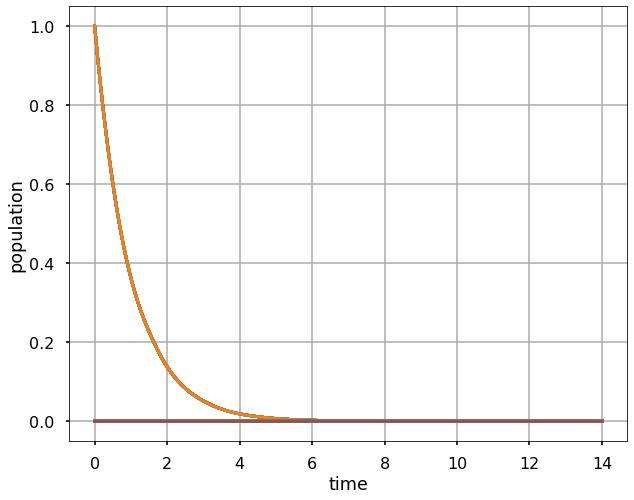

In [19]:
plt.figure(figsize = (10, 8))
[plt.plot(sol.t, sol.y[i, :]) for i in range(total_articles)]
plt.xlabel('time')
plt.ylabel('population')

#plt.legend(['solution {}'.format(i) for i in range(len(sol.y[:total_articles]))])
plt.grid(True)
plt.show()

In [14]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 56
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0.        ,  0.93333333,  1.86666667,  2.8       ,  3.73333333,
        4.66666667,  5.6       ,  6.53333333,  7.46666667,  8.4       ,
        9.33333333, 10.26666667, 11.2       , 12.13333333, 13.06666667,
       14.        ])
 t_events: None
        y: array([[1.00000000e+00, 3.71580421e-01, 1.70253180e-01, ...,
        2.10315047e-05, 7.33480727e-06, 4.38898563e-06],
       [0.00000000e+00, 1.05541360e-05, 4.04687757e-06, ...,
        9.86042697e-10, 6.32971448e-10, 1.75195293e-10],
       [0.00000000e+00, 1.05541360e-05, 4.04687757e-06, ...,
        9.86042697e-10, 6.32971448e-10, 1.75195293e-10],
       ...,
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.000

In [ ]:
# def plot_sol(sol, color_dict, domains):
#     plots = list_plot([(j[0],j[1][0]) for j in sol[:total_articles]], color=color_dict[domains[0]], plotjoined=True, alpha=.8, gridlines=true)
#     for i in range(500):
#         co = color_dict[domains[i]]
#         plots += list_plot([(j[0], j[1][i]) for j in sol[:total_articles]], color=co, plotjoined=True, alpha=.2, gridlines=true)
#     plots.save('../data//simulation.png')



## dI- matrix com a probabilidade do artigo ser infectado no tempo t. dI[0] - artigos infectados no tempo 0
## Infects - matrix boolean com os infectados no tempo t.
## recebe T.solution

def create_dI(sol):
    s = len(T.solution[0][1])/2
    dI = np.zeros((len(T.solution), s))
    dS = np.zeros((len(T.solution), s))
    c = 0
    for i,v in sol:
        dI[c:] = v[:s]
        dS[c:] = v[s:]
        c+=1
    return dI, dS

def create_infects(dI,dS):
    dR = 1-(dS+dI)

    Infects = np.zeros(dI.shape)
    Infects[0] = dI[0]

    S0 = np.ones(dI.shape[1]) - Infects[0]
    R0 = np.zeros(dI.shape[1])
    I0 = Infects[0]

    for t in range(1,dI.shape[0]):

        I = bernoulli.rvs(dI[t]*S0)
        R = bernoulli.rvs(dR[t]*I0)

        Infects[t] = I0 - R + I
        a = Infects[t]

        if len(a[a<0]) > 0:
            b = I0-R
            if len(b[b<0])>0:
                print('ei')


        I0 = Infects[t]
        S0 = S0 - I

    return(Infects)


def create_infected_matrix(la, T):
    T.ode_solve(t_span=[0, 14], y_0=list(i0)+list(s0), num_points=16, params=[G, la])
    plot_sol(T.solution, color_dict, domains)

    dI, dS = create_dI(T.solution)
    Infects = create_infects(dI,dS)

    return dI, Infects


In [ ]:


T = ode_solver()
T.algorithm = "rkf45"
T.function = fun
l = 0.0000215


dI, Infects = create_infected_matrix(l, T)
np.savetxt('../data//dI.csv', dI, delimiter=',')
np.savetxt('../data//Infects.csv', Infects, delimiter=',')